# L2: Perturbation analysis and other methods to interpret models

The techniques presented in this notebook allow for a better model analysis and debugging capability. If L1 techniques can tell you how good or bad a model is, L2 will help you understand how/when the model is not good.

### Setup

In [1]:
import numpy as np

np.random.seed(41)

import shap

X, y = shap.datasets.adult()
# if you want the dataset with string values for fields like Relationship, or Marital Status, set display=True

In [2]:
X.sample(5)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
31346,64.0,1,10.0,2,14,4,4,1,0.0,0.0,40.0,39
26864,17.0,4,7.0,4,8,3,4,0,0.0,0.0,5.0,39
30544,24.0,4,10.0,4,6,3,4,1,0.0,0.0,30.0,39
17397,45.0,4,10.0,2,3,4,4,1,0.0,1848.0,40.0,39
10168,28.0,4,13.0,4,10,0,4,0,0.0,0.0,40.0,39


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [4]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [5]:
knn.score(X_valid, y_valid)

0.8464609243052357

### Check most wrong predictions

Let's first see how to get the most wrong predictions.

In [6]:
predictions = knn.predict_proba(X_valid)
hard_predictions = np.where(predictions > 0.5, 1, 0)[:, 1]

We need a way to order our predictions by confidence, that's why we're using `.predict_proba`. For classifiers that don't have `.predict_proba`, like SVMs or other maximum margin classifiers, it is in principle possible to use `.decision_function` or you could wrap the model into some kind of calibration class and to get `.predict_proba`, or just try to infer it from `.decision_function`.

In [7]:
top_wrongs = predictions[y_valid != hard_predictions][:, 1]

In [8]:
top_10_wrongs_ids = list(sorted(((idx, top_wrongs[idx])
                              for idx in range(len(top_wrongs))
                                  if top_wrongs[idx] > top_wrongs.mean()), # this line is optional
                          key=lambda x: x[1], reverse=True))[:10]

In [9]:
top_10_wrongs_ids

[(20, 1.0),
 (44, 1.0),
 (113, 1.0),
 (190, 1.0),
 (219, 1.0),
 (233, 1.0),
 (259, 1.0),
 (273, 1.0),
 (274, 1.0),
 (293, 1.0)]

In [10]:
X_valid.iloc[[idx for idx, _ in top_10_wrongs_ids]]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
22264,31.0,4,10.0,4,12,2,4,0,0.0,0.0,40.0,0
20764,30.0,1,13.0,4,10,0,4,1,0.0,1876.0,40.0,39
9220,55.0,4,9.0,5,1,0,4,0,0.0,0.0,40.0,39
23183,39.0,2,9.0,2,3,4,4,1,0.0,0.0,40.0,39
22932,23.0,4,9.0,4,8,0,2,1,0.0,0.0,30.0,39
29130,17.0,4,5.0,4,8,3,4,1,0.0,0.0,16.0,39
10266,56.0,5,5.0,2,14,4,4,1,0.0,0.0,99.0,39
4881,25.0,4,13.0,4,3,0,4,1,0.0,0.0,40.0,26
66,28.0,4,10.0,0,1,0,4,0,0.0,0.0,40.0,39
8656,36.0,6,13.0,0,8,1,2,1,0.0,0.0,45.0,39


## Input alterations for model verification

Although random alterations and counterfactuals are more or less the same, I prefer to have a delimitation, where counterfactuals mean alterations of important features, while random alterations are manipulations of non-informative features.

I.e. in NLP, for a sentiment classification model, if I switch the word _amazing_ with the word _horrible_ I should get a different prediction. That is a counterfactual, for me. On the other hand, if I drop a few words like prepositions or verbs, or intentionally commit grammar mistakes, at least in theory, it shouldn't change the prediction. That I would call a random alteration.

### Counterfactuals and Random alterations

In [11]:
example = X_train.iloc[0]
print(f"Earns over 50k?", y_train[0])
example

Earns over 50k? False


Age               51.0
Workclass          4.0
Education-Num     10.0
Marital Status     0.0
Occupation         6.0
Relationship       0.0
Race               4.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           21.0
Name: 12011, dtype: float64

In [12]:
knn.predict([example]) # that is the person doesn't earn more than 50k a year

array([False])

In [13]:
# What if said person would work 60h instead of 40h a week?
example["Hours per week"] = example["Hours per week"] * 1.25


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
knn.predict([example])

array([ True])

Now let's try tinkering with the age attribute.

In [15]:
example = X_train.iloc[0]
print(f"Earns over 50k?", y_train[0])
print(example)

print("Prediction before:", knn.predict([example]))

example["Age"] = 80

print("Prediction after:", knn.predict([example]))

Earns over 50k? False
Age               51.0
Workclass          4.0
Education-Num     10.0
Marital Status     0.0
Occupation         6.0
Relationship       0.0
Race               4.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           21.0
Name: 12011, dtype: float64
Prediction before: [False]
Prediction after: [False]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
example = X_train.iloc[0]
print(f"Earns over 50k?", y_train[0])
print(example)

print("Prediction before:", knn.predict([example]))

example["Age"] = 65

print("Prediction after:", knn.predict([example]))

Earns over 50k? False
Age               51.0
Workclass          4.0
Education-Num     10.0
Marital Status     0.0
Occupation         6.0
Relationship       0.0
Race               4.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           21.0
Name: 12011, dtype: float64
Prediction before: [False]
Prediction after: [ True]



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


What about trickier attributes?

In [17]:
example = X_train.iloc[0]
print(f"Earns over 50k?", y_train[0])
example

Earns over 50k? False


Age               51.0
Workclass          4.0
Education-Num     10.0
Marital Status     0.0
Occupation         6.0
Relationship       0.0
Race               4.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           21.0
Name: 12011, dtype: float64

In [18]:
knn.predict([example])

array([False])

In [19]:
# Normally we wouldn't want gender to influence the outcome
example.Sex = not example.Sex


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# ... and it doesn't, at least for this example
knn.predict([example])

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


array([False])

Of course it is possible to check whenever the model changed it's predictions for all validation data points, not just for a few handpicked examples.

## ML Interpretability for model verification (PDP/ICE plots, Local Surogate Models, Additive explanations)

I personally don't use PDP/ICE plots, because I find those pretty hard to interpret. It might not be the case for you. So give it a try.

**PDP** stands for partial dependency plot, and **ICE** is individual conditional expectation plot. PDP allows to better understand the relation between one or two features and the target. PDP is a summary, while ICE show this dependency for each input example separately (see plots below).


I would really suggest you look up [this tutorial](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html) about both.

Also, beware, even on a reduced dataset both PDP and ICE are pretty slow.

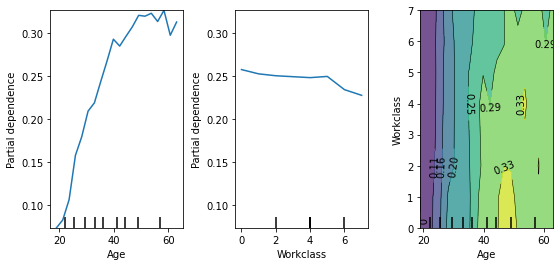

In [29]:
# this is a PDP example
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt


_, ax = plt.subplots(ncols=3, figsize=(9, 4))

features = [0, 1, (0, 1)] # first two are individual features, third allows the analysis of feature interaction
display = plot_partial_dependence(knn, X[:1000], features, n_jobs=4,
                                  subsample=50, grid_resolution=20, ax=ax)

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

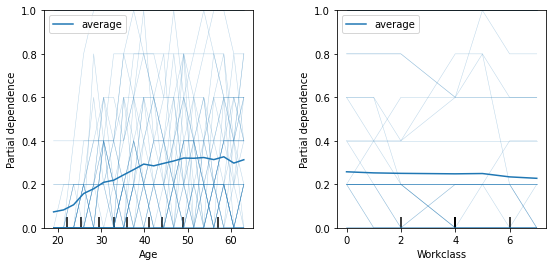

In [31]:
# and this is an ICE example
_, ax = plt.subplots(ncols=2, figsize=(9, 4))

display = plot_partial_dependence(knn, X[:1000], [0, 1], n_jobs=4,
                        kind="both", subsample=50, grid_resolution=20, ax=ax)

display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

## SHAP and LIME

SHAP is an additive feature explanation tool which by look and feel is a bit like LIME, which is a surrogate local explanation tool. What is important to understand is that both tools allow for local explanations, that is explaining one sample at a time. On the other hand `.feature_importance_` attribute of some ML models from scikit-learn is a global explanation, because this attribute is computed based on "average" feature importance.

For more information about both see https://blog.cloudera.com/ml-interpretability-lime-and-shap-in-prose-and-code/. And to better understand the SHAP visualizations below, [consult their documentation](https://shap.readthedocs.io/en/latest/index.html).

Below you will first find examples of using SHAP and then LIME.

### SHAP

In [22]:
import shap


predict_func = lambda x: knn.predict_proba(x)[:,1]
medians = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(predict_func, medians)
shap_values = explainer(X_valid.iloc[0:1000, :])

Permutation explainer: 1001it [01:17, 11.50it/s]                         


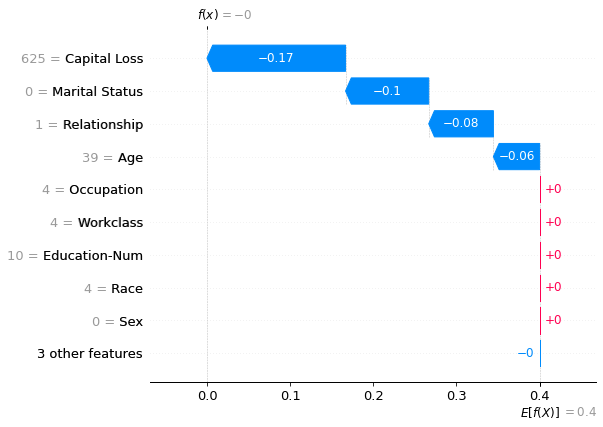

In [23]:
shap.plots.waterfall(shap_values[0])

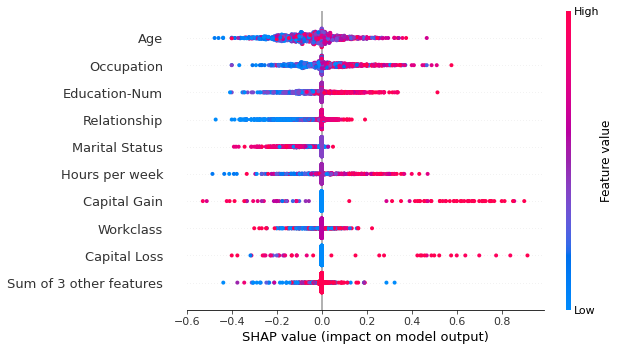

In [24]:
shap.plots.beeswarm(shap_values)

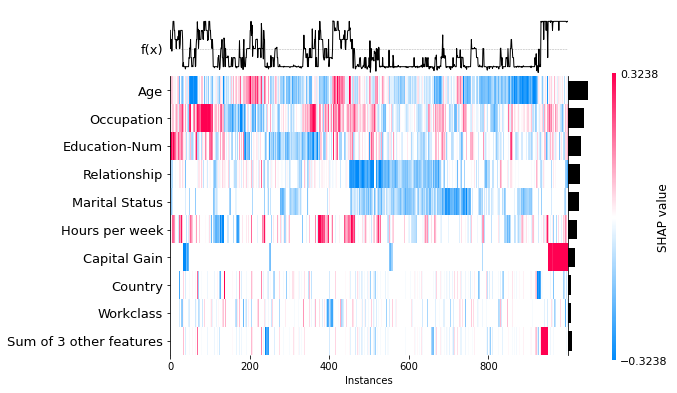

In [ ]:
shap.plots.heatmap(shap_values)

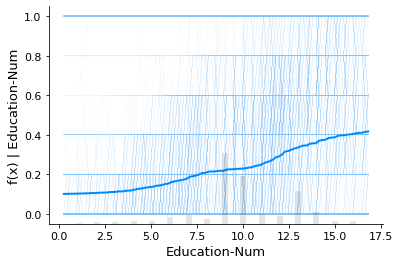

In [ ]:
shap.plots.partial_dependence("Education-Num", predict_func, X_valid.iloc[:1000])

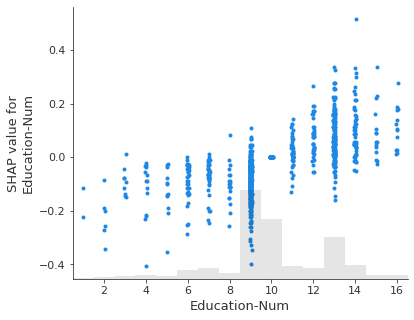

In [ ]:
shap.plots.scatter(shap_values[:,"Education-Num"])

In [14]:
shap.initjs()

In [ ]:
# this one is slow as hell + good luck figuring out what does this plot tells you
explainer = shap.KernelExplainer(knn.predict_proba, X_train.sample(100))
shap_values = explainer.shap_values(X_valid.sample(100))

In [15]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_valid.sample(100))

### LIME

In [18]:
# Source: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Using%20lime%20for%20regression.ipynb
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import numpy as np

In [19]:
boston = load_boston()

In [20]:
rf = RandomForestRegressor(n_estimators=1000)

In [21]:
train, test, labels_train, labels_test = train_test_split(boston.data, boston.target,
                                                          train_size=0.80, test_size=0.20)

In [22]:
rf.fit(train, labels_train)

RandomForestRegressor(n_estimators=1000)

In [23]:
print('Random Forest MSE', np.mean((rf.predict(test) - labels_test) ** 2))

Random Forest MSE 11.769912799803969


In [25]:
print('MSE when predicting the mean', np.mean((labels_train.mean() - labels_test) ** 2))

MSE when predicting the mean 91.21578362055047


In [26]:
categorical_features = np.argwhere(np.array([len(set(boston.data[:,x]))
                                             for x in range(boston.data.shape[1])]) <= 10).flatten()

In [27]:
import lime
import lime.lime_tabular

In [28]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names,
                                                   class_names=['price'],
                                                   categorical_features=categorical_features,
                                                   verbose=True, mode='regression')

In [29]:
i = 25
exp = explainer.explain_instance(test[i], rf.predict, num_features=5)

Intercept 21.376224426411977
Prediction_local [30.97005449]
Right: 32.363600000000254


In [30]:
exp.show_in_notebook(show_table=True)

In [31]:
exp.as_list()

[('RM > 6.63', 7.265152738272734),
 ('6.89 < LSTAT <= 11.04', 0.710637210070409),
 ('TAX <= 279.75', 0.555592037067107),
 ('0.45 < NOX <= 0.54', 0.5408470567614437),
 ('AGE <= 42.03', 0.5216010199496779)]